# Case Study Objective 

### To Identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 


# Data Overview

In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import scorecardpy as sc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from optbinning import BinningProcess
from xgboost import XGBClassifier
import sweetviz as sv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

## Train data

In [3]:
print("Number of rows : ",train_df.shape[0]) 
print("Number of columns : ",train_df.shape[1]) 

Number of rows :  200000
Number of columns :  202


In [4]:
train_df.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


ID_code represents row id <br>
target represents the dependent variable<br>
var_0 - var_199 are the independent variables

In [5]:
desc_df = train_df.describe()

In [6]:
desc_df.min(axis=1)

count    200000.000000
mean        -16.548147
std           0.007186
min         -90.252500
25%         -28.730700
50%         -16.482600
75%          -6.409375
max           1.000000
dtype: float64

In [7]:
desc_df.max(axis=1)

count    200000.000000
mean         24.521078
std          21.404912
min          13.729000
25%          16.047975
50%          24.445000
75%          33.633150
max          74.032100
dtype: float64

The data description shows a significant variability in standard deviation.<br>
Variables with higher standard deviations have a wider spread of values, signifying greater variability.<br>
While those with lower standard deviations have values that are more closely clustered around the mean, imply lower variability.

## Test data

In [8]:
print("Number of rows : ",test_df.shape[0]) 
print("Number of columns : ",test_df.shape[1]) 

Number of rows :  200000
Number of columns :  201


In [9]:
test_df.head(2)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760


Test_df doesnt have target as expected

In [10]:
desc_test_df = test_df.describe()

In [11]:
desc_test_df.min(axis=1)

count    200000.000000
mean        -16.334976
std           0.007194
min         -83.692100
25%         -28.673200
50%         -16.188350
75%          -6.207550
max           1.516500
dtype: float64

In [12]:
desc_test_df.max(axis=1)

count    200000.000000
mean         24.536099
std          21.402708
min          13.737900
25%          16.129275
50%          24.426900
75%          33.598525
max          84.684100
dtype: float64

In checking the statistical summary of both the training and testing datasets, it becomes evident that their data distributions exhibit similarities.<br>
However, further investigation in subsequent sections will be conducted to assess the similiarity at a granular level.

## Target Distribution

In [13]:
print("Percentage of customers who made the transaction(%) : ",train_df.target.mean()*100)

Percentage of customers who made the transaction(%) :  10.049


# Data Preprocessing

## Drop variables with no information

In [14]:
train_df.drop('ID_code',axis=1,inplace=True)

## Checking missing values

In [15]:
missing_df = pd.DataFrame(train_df.isna().sum())
missing_df[missing_df[0]>0]

,0


There are no missing values

## Checking high correlation

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['target'],axis=1), train_df['target'],test_size=0.2, random_state=456,shuffle=True,stratify=train_df['target'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160000, 200), (40000, 200), (160000,), (40000,))

In [17]:
cor_matrix = X_train.corr().abs()
corr_df = pd.DataFrame(cor_matrix,columns = X_train.columns,index = X_train.columns)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.95)]
to_drop

[]

No variables have high correlation(>0.95)

In [18]:
X_train1 = X_train
v_thresh = VarianceThreshold(threshold = 0)
v_thresh.fit(X_train1)
selected_features = list(X_train1.columns[v_thresh.get_support()])
print("Variables with zero variance : ",len(X_train1.columns)-len(selected_features))



Variables with zero variance :  0


# Exploratory Data Analysis

In [19]:
# sv_report = sv.compare(
# [train_df.drop('target',axis=1),"training"],
# [test_df,"test"],
# None,pairwise_analysis='off')

# name = 'EDA.html'
# sv_report.show_html(name)

Please refer pdf - "EDA.html"

I reviewed graphs for all 200 variables and observed that the data distribution is similar in both the training and test datasets

# Feature Engineering

## Adding general statistics

In [20]:
og_variable_names= list(train_df.columns)
og_variable_names.remove('target')

train_df['Sum'] = train_df[og_variable_names].sum(axis=1)
train_df['Min'] = train_df[og_variable_names].min(axis=1)
train_df['Max'] = train_df[og_variable_names].max(axis=1)
train_df['Mean'] = train_df[og_variable_names].mean(axis=1)
train_df['Std'] = train_df[og_variable_names].std(axis=1)
train_df['Skew'] = train_df[og_variable_names].skew(axis=1)
train_df['Kurtosis'] = train_df[og_variable_names].kurt(axis=1)

stats_variable_names= list(train_df.columns)
stats_variable_names.remove('target')

## Adding features with their WOE

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['target'],axis=1), train_df['target'],test_size=0.20, random_state=456,shuffle=True,stratify=train_df['target'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160000, 207), (40000, 207), (160000,), (40000,))

In [22]:
binning_process = BinningProcess(variable_names=stats_variable_names,min_bin_size = 0.05,
                                 binning_fit_params={"valuation": {"cat_cutoff": 0.05}})

binning_process.fit(X_train[stats_variable_names],y_train)


binning_process_binning_table = pd.DataFrame()

for variable in stats_variable_names:
    optb = binning_process.get_binned_variable(name=variable)
    binning_process_binning_table0 = optb.binning_table.build()
    binning_process_binning_table0['variable'] = variable
    binning_process_binning_table = pd.concat([binning_process_binning_table, binning_process_binning_table0], axis=0)

In [23]:
X_train_bin = binning_process.transform(X_train[stats_variable_names])
X_test_bin = binning_process.transform(X_test[stats_variable_names])

In [24]:
X_train = X_train.join(X_train_bin,how='left', lsuffix='', rsuffix='_woe')
X_test = X_test.join(X_test_bin,how='left', lsuffix='', rsuffix='_woe')

In [25]:
complete_variable_names= list(X_train.columns)

## Final overview of training dataset

In [26]:
X_train.shape

(160000, 414)

In [27]:
X_train.head(2)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_197_woe,var_198_woe,var_199_woe,Sum_woe,Min_woe,Max_woe,Mean_woe,Std_woe,Skew_woe,Kurtosis_woe
61895,6.3878,-1.1235,4.7372,6.6282,11.1925,-15.1934,5.2441,20.4916,-4.6741,8.3217,...,-0.481553,-0.604262,0.040851,0.077029,0.171751,-0.070992,0.077029,0.038874,0.100160,0.001384
154469,10.9042,2.0223,13.2297,8.9495,12.8242,-3.2768,6.3560,18.9167,4.3623,8.7805,...,-0.004795,0.132623,-0.002271,0.059331,0.052811,-0.070992,0.059331,0.065890,0.001931,0.026066


Original variables - 200 <br>
Stats variables - 7 <br>
Binned variables - 207

# Data Modeling

In [28]:
X_train.isna().sum()

var_0               0
var_1               0
var_2               0
var_3               0
var_4               0
                ...  
Max_woe         32239
Mean_woe        32239
Std_woe         32239
Skew_woe        32239
Kurtosis_woe    32239
Length: 414, dtype: int64

In [29]:
# WOE features have missing values
X_train1 = X_train.fillna(0)
X_test1 = X_test.fillna(0)

## Logistic Regression

In [30]:
logR = LogisticRegression(random_state=145)
logR.fit(X_train1, y_train)
train_pred = logR.predict_proba(X_train1)[::,1]
test_pred = logR.predict_proba(X_test1)[::,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

C:\Users\sawla\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training ROC AUC score :  0.8326
Test ROC AUC score :  0.8367


In [54]:
xgb = XGBClassifier(random_state=145)
xgb.fit(X_train, y_train)
train_pred = xgb.predict_proba(X_train)[:,1]
test_pred = xgb.predict_proba(X_test)[:,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.9821
Test ROC AUC score :  0.866


In [32]:
ligbm_model = lgb.LGBMClassifier(random_state=145)
ligbm_model.fit(X_train, y_train)
train_pred = ligbm_model.predict_proba(X_train)[:,1]
test_pred = ligbm_model.predict_proba(X_test)[:,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.9251
Test ROC AUC score :  0.8726


## LiGBM has the best performance out of all the three models

|Model Name|Train AUC |Test AUC|Comments|
| --- | --- | --- | --- |
|Logistic Regression|0.8326|0.8367|Less predictability power|
|XGBoost|0.9821|0.866|Overfitted model|
|LiGBM|0.9251|0.8726|Optimal performance|

## Feature selection

In [33]:
# using original features
ligbm_model = lgb.LGBMClassifier(random_state=145)
ligbm_model.fit(X_train[og_variable_names], y_train)
train_pred = ligbm_model.predict_proba(X_train[og_variable_names])[:,1]
test_pred = ligbm_model.predict_proba(X_test[og_variable_names])[:,1]

print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.9246
Test ROC AUC score :  0.8735


In [34]:
# using original features plus stats_variables
ligbm_model = lgb.LGBMClassifier(random_state=145)
ligbm_model.fit(X_train[stats_variable_names], y_train)
train_pred = ligbm_model.predict_proba(X_train[stats_variable_names])[:,1]
test_pred = ligbm_model.predict_proba(X_test[stats_variable_names])[:,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.9251
Test ROC AUC score :  0.8735


In [35]:
stats_woe_variables = list(set((X_train.columns)) - set(og_variable_names))

ligbm_model = lgb.LGBMClassifier(random_state=145)
ligbm_model.fit(X_train[stats_woe_variables], y_train)
train_pred = ligbm_model.predict_proba(X_train[stats_woe_variables])[:,1]
test_pred = ligbm_model.predict_proba(X_test[stats_woe_variables])[:,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.7507
Test ROC AUC score :  0.5458


## LiGBM with actual plus stats variables has the optimal performance

|Features|Train AUC |Test AUC|Comments|
| --- | --- | --- | --- |
|Original Features|0.9246|0.8735|Optimal Model|
|OG plus stats|0.9251|0.8735||
|All features|0.9251|0.8726||
|All features - OG|0.7555|0.5476|Unpredictive model|

# Hyper parameter tuning with selected variables

In [36]:
# using original features
ligbm_model = lgb.LGBMClassifier(random_state=145)
ligbm_model.fit(X_train[og_variable_names], y_train)
train_pred = ligbm_model.predict_proba(X_train[og_variable_names])[:,1]
test_pred = ligbm_model.predict_proba(X_test[og_variable_names])[:,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.9246
Test ROC AUC score :  0.8735


In [37]:
# param_grid = {
#     'n_estimators': range(50,500,10),
#     'max_depth': [3, 4, 5, 6,7,8,9,10],
#     'learning_rate': [0.0001,0.001,0.01, 0.1, 0.5,1,10,100],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.5, 0.7, 1.0],
#     'reg_lambda' :  [0.01,0.1, 1, 10, 100],
#     'reg_alpha' : [0.01,0.1, 1, 10,100]
# }

# rand_search = RandomizedSearchCV(ligbm_model,
#                                  param_distributions = param_grid,
#                                  cv=10)

# # Fit the random search object to the data
# rand_search.fit(X_train[og_variable_names], y_train)

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=145),
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.5, 1, 10,
                                                          100],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': range(50, 500, 10),
                                        'reg_alpha': [0.01, 0.1, 1, 10, 100],
                                        'reg_lambda': [0.01, 0.1, 1, 10, 100],
                                        'subsample': [0.5, 0.7, 1.0]})

In [51]:
# cv_results = pd.DataFrame(rand_search.cv_results_)

In [52]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,155.818732,433.408559,0.126300,0.024762,0.5,0.01,0.1,90,10,0.5,...,0.909875,0.909625,0.910312,0.913875,0.910188,0.911188,0.909312,0.910369,0.001620,1
1,8.565915,0.327529,0.119512,0.008103,0.7,0.01,0.01,100,5,1,...,0.885625,0.881938,0.885750,0.886500,0.887687,0.887938,0.886312,0.885819,0.002095,8
2,11.807762,0.195754,0.183306,0.007665,0.5,0.01,100,320,4,0.01,...,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899512,0.000025,3
3,13.427193,0.148596,0.208709,0.012132,1.0,10,10,390,4,0.01,...,0.899500,0.899500,0.899500,0.899500,0.899563,0.899500,0.899500,0.899519,0.000029,2
4,8.668451,0.108899,0.100535,0.008809,0.7,1,1,80,6,0.01,...,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899512,0.000025,3
5,6.999956,0.139302,0.070400,0.015671,1.0,100,0.1,130,7,10,...,0.699500,0.827625,0.899438,0.779062,0.868437,0.812438,0.893875,0.830838,0.058481,9
6,9.068620,0.147910,0.114716,0.007767,0.7,10,100,130,5,0.0001,...,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899512,0.000025,3
7,7.194453,0.126648,0.116276,0.016789,1.0,10,100,60,10,0.1,...,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899512,0.000025,3
8,12.663383,0.146859,0.126029,0.006665,0.7,1,10,90,10,0.01,...,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899500,0.899512,0.000025,3
9,6.008239,0.135387,0.064580,0.004635,1.0,1,1,60,5,100,...,0.707063,0.444563,0.133500,0.672750,0.899438,0.422000,0.896750,0.633381,0.255042,10


In [53]:
# best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
# print('Best hyperparameters:',  rand_search.best_params_)

In [40]:
# using original features


ligbm_model = lgb.LGBMClassifier(subsample= 0.5, reg_lambda= 0.1,
                                 reg_alpha= 1, n_estimators= 450,
                                 max_depth= 3, learning_rate= 0.05, 
                                 colsample_bytree= 1,random_state=145,
                                 is_unbalance=True,min_data_in_bin=10)
ligbm_model.fit(X_train[og_variable_names], y_train)
train_pred = ligbm_model.predict_proba(X_train[og_variable_names])[:,1]
test_pred = ligbm_model.predict_proba(X_test[og_variable_names])[:,1]
print("Training ROC AUC score : ",round(roc_auc_score(y_train,train_pred),4))
print("Test ROC AUC score : ",round(roc_auc_score(y_test, test_pred),4))

Training ROC AUC score :  0.9019
Test ROC AUC score :  0.8737


Hyper parameter tuning is used fine tune the model by reducing over fitting if there is any.<br>
Important parameters(not limited to) that reduce overfitting are : <br>
* max_depth
* min_data_in_bin<br>

Parameter that handles data imbalance is :
* is_unbalance


# Final Variables of Model

In [41]:
# feature_imp = pd.DataFrame(sorted(zip(ligbm_model.feature_importances_,X_train[og_variable_names].columns)), columns=['Value','Feature'])
# feature_imp = feature_imp.sort_values(by='Value', ascending=False)
# feature_imp[feature_imp['Value']>0]

LiGBM model has selected 155/200 variables as final variables

In [42]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Top 20 Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

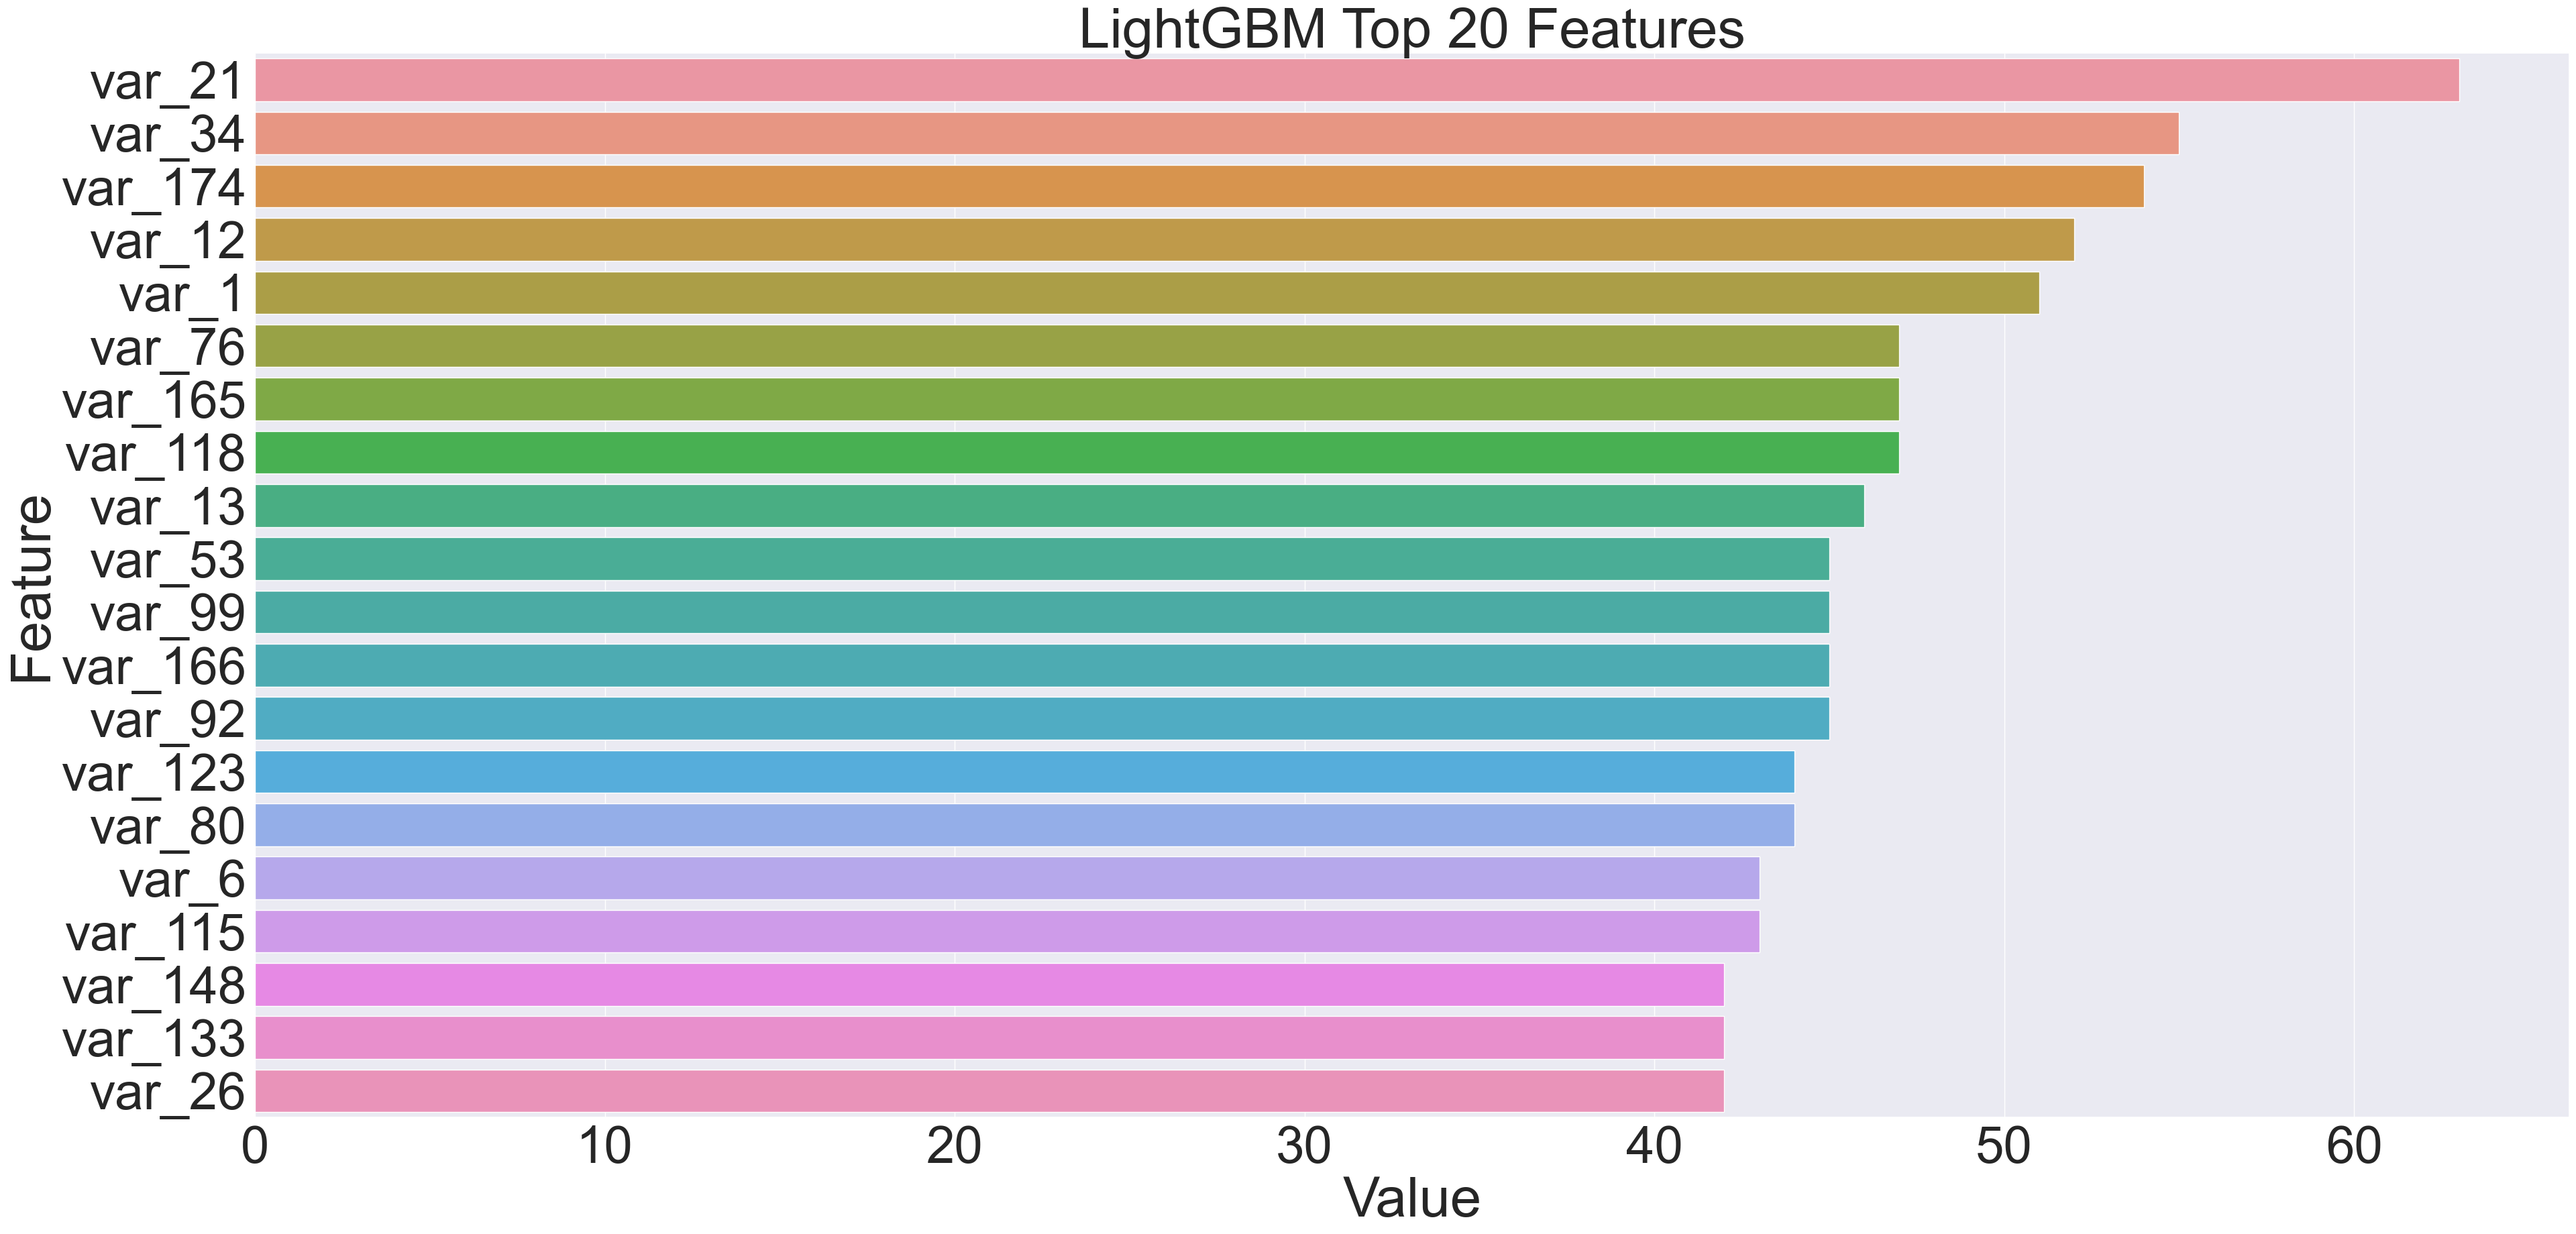

In [43]:
plotImp(ligbm_model,X_train[og_variable_names],num = 20)


# Model Evaluation

In [44]:

test_df['target'] = ligbm_model.predict_proba(test_df[og_variable_names])[:,1]

In [45]:
# Exporting in required format
sample_df = pd.read_csv('sample_submission.csv')

In [46]:
sample_df.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [47]:
test_df[['ID_code','target']].to_csv("Submission.csv")

## Performance Evaluation


|data sample|AUC ROC score|
| --- |---|
|X_train | 0.9019 |
|X_validation | 0.8737 |
|test sample(kaggle public score) | 0.86691|
|test sample(kaggle private score) | 0.86285|

# Model Applicability in real life

In [48]:
train_df['prob_class1'] = ligbm_model.predict_proba(train_df[og_variable_names])[:,1]
train_df['prob_class0'] = ligbm_model.predict_proba(train_df[og_variable_names])[:,0]

In [49]:
train_df['class1_bins'] = pd.qcut(train_df['prob_class1'], 5)

In [50]:
train_df[['class1_bins','target']].groupby('class1_bins').agg(['count','mean']).sort_values('class1_bins',ascending=False)

target          
                 count      mean
class1_bins                     
(0.521, 0.981]   40000  0.380825
(0.396, 0.521]   40000  0.078000
(0.309, 0.396]   40000  0.028575
(0.232, 0.309]   40000  0.012000
(0.0587, 0.232]  40000  0.003050

This scorecard categorizes applications by their assigned probabilities and transaction rates:

- The first column shows probability bins.
- The second column has application counts (40,000 each).
- The third column indicates percentage transactions made in each bin.

Key insights:

- As probability increases, transaction rates increase.
- Low-probability range: (0.0587, 0.232] with 0.30% transaction rate.
- High-probability range: (0.521, 0.981] with 38.08% transaction rate.
- Valuable for outcome-based decisions, resource allocation, and model improvement.

# Model deployment

Please find below an approach for productionization of a machine learning model stored in a **pickle file** using AWS SageMaker:

**a. Tools and Technologies:**

1. **Amazon SageMaker:** The core service for building, training, and deploying machine learning models.
2. **Amazon S3:** To store the pickle model file and any additional data.
3. **Amazon Lambda:** For serverless execution of code, like preprocessing data or invoking the SageMaker endpoint.
4. **Amazon API Gateway:** To create APIs for the model's predictions.
5. **Amazon CloudWatch:** For monitoring and logging.
6. **AWS Identity and Access Management (IAM):** For managing permissions and roles.

**b. Architecture Design:**

1. **Data Preparation and Model Training:**
   - Upload the pickle model file and any necessary dependencies to an S3 bucket.

2. **Model Deployment:**
   - Deploy the model as an endpoint in SageMaker.
   
3. **API Creation:**
   - Use Amazon Lambda to preprocess incoming data (if needed) and make predictions using the deployed SageMaker endpoint.
   - Create an API using Amazon API Gateway that triggers the Lambda function, effectively exposing your model as an API endpoint.

**c. Scheduling and Monitoring:**

1. **Monitoring:**
   - Set up CloudWatch metrics to monitor endpoint health, performance, and resource usage.
   - Set up CloudWatch Logs for logging relevant events and activities.

2. **Alerting:**
   - Configure CloudWatch alarms to trigger notifications if certain conditions (e.g., high error rate) are met.

3. **Scheduling:**
   - If your model requires periodic updates, use AWS Step Functions to automate the process: trigger data preparation, training, and model deployment in a sequential manner.

**d. Scaling:**

1. **Model Scaling:**
   - SageMaker automatically scales the deployed model based on the incoming traffic. You can adjust the instance count and type to handle varying loads.

2. **Endpoint Scaling:**
   - For high traffic scenarios, you can deploy multiple instances of your endpoint behind a load balancer to distribute requests.

3. **Data Preprocessing:**
   - If preprocessing is resource-intensive, use Lambda's auto-scaling to handle concurrent preprocessing requests.

4. **API Scaling:**
   - API Gateway automatically scales based on incoming API traffic.

By following this architecture, you can effectively productionize your model stored in a pickle file using Amazon SageMaker, leveraging various AWS services for deployment, monitoring, scaling, and automation.